# Data Storage

## Install libraries & packages

In [5]:
## Install libraries & install packages needed to run MongoDB
import requests
import time
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
import pandas as pd
import seaborn as sns
os.environ['PATH'] += os.pathsep + '/usr/local/bin' 

## Start Docker container

In [30]:
docker run

SyntaxError: invalid syntax (736237006.py, line 1)

### Check if the services are running

In [3]:
!docker ps

/bin/sh: 1: docker: not found


## Connect to DB

# Process CSV Data

### Install necessary packages

In [4]:
!pip install pymongo

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


### Read data and display the first few rows

In [ ]:
import pandas as pd

# Read the CSV file with the specified encoding
poi_df = pd.read_csv('data/top-locations-wien.csv', encoding='latin1', sep=';')


# Display the first few rows of the dataframe
print(poi_df.head())

             title    category  \
0        21er Haus      museum   
1   A.E. Kï¿½chert    shopping   
2             Aida       cafes   
3  Akademietheater  musicstage   
4        Albertina      museum   

                                        Beschreibung                  address  \
0  Das Museum wurde 2011 saniert und stellt unter...        Arsenalstraï¿½e 1   
1  Dieser Traditions-Juwelier schmï¿½ckt heute mi...          Neuer Markt 15    
2  Aida ist eine Wiener Konditoreikette. Das Desi...  Stock-im-Eisen-Platz 2    
3  Seit 1922 ist das Akademietheater die zweite S...          Lisztstraï¿½e 1   
4  Die Albertina besitzt nicht nur eine der grï¿½...        Albertinaplatz 1    

    zip  city      geo_latitude     geo_longitude             tel_1  \
0  1030  Wien  48,1857710810320  16,3836224650817  +43 1 795 57-134   
1  1010  Wien        48,2065731        16,3705892               NaN   
2  1010  Wien        48,2080194        16,3720473  +43 1 512 79 25    
3  1030  Wien        48,

In [ ]:
# Create new DataFrame for the Vizualisation (category and coordinates)

# Auswahl der gewünschten Spalten
new_df = poi_df[['category', 'geo_latitude', 'geo_longitude']]

# Ausgabe des neuen DataFrames
print(new_df)

### Check for missing values

In [ ]:
print(new_df.isnull().sum())

title              0
category           0
Beschreibung       0
address            3
zip                0
city               0
geo_latitude       0
geo_longitude      0
tel_1             22
tel_1_comment    100
tel_2            129
tel_2_comment    130
tel_3            132
tel_3_comment    132
email             80
web_url            6
url                7
dtype: int64


### CSV-Data cleaning

In [ ]:
# Fill or drop missing values
new_df = new_df.dropna()  # Dropping rows with missing values

# Check for duplicates
print(new_df.duplicated().sum())

# Remove duplicates
new_df = new_df.drop_duplicates()

0


### Show clean Dataframe

In [ ]:
print(new_df.head())

Empty DataFrame
Columns: [title, category, Beschreibung, address, zip, city, geo_latitude, geo_longitude, tel_1, tel_1_comment, tel_2, tel_2_comment, tel_3, tel_3_comment, email, web_url, url]
Index: []


## Save data in MongoDB

In [ ]:
# Connect to MongoDB
client = MongoClient('localhost', 37017)
db = client['citybike_vienna']
collection = db['top_locations_wien']

# Insert data into MongoDB
collection.insert_many(new_df.to_dict('records'))

print("Data inserted into MongoDB")

NameError: name 'MongoClient' is not defined

## Analyse and Vizualisation of CSV-Data

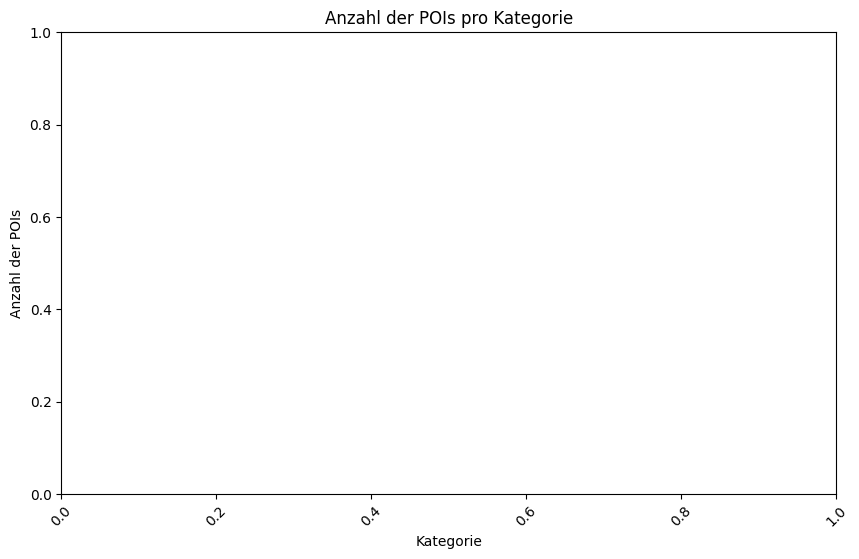

In [ ]:
# Anzahl der POIs pro Kategorie
category_counts = new_df['category'].value_counts()

# Plotting the number of POIs per category
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Anzahl der POIs pro Kategorie')
plt.xlabel('Kategorie')
plt.ylabel('Anzahl der POIs')
plt.xticks(rotation=45)
plt.show()

## Linking the data with Citybike locations

In [ ]:
# Mock data for Citybike locations and usage

citybike_locations = {
    "Museum": 10,
    "Cafe": 15,
    "Nightlife": 5,
    "Park": 8,
    "Shopping": 12
}

# Assuming we have a similar structure for the POIs and Citybike locations
new_df['Citybike_Standorte'] = new_df['Kategorie'].map(citybike_locations)

# Plotting the number of Citybike locations per POI category
plt.figure(figsize=(10, 6))
sns.barplot(x=new_df['Kategorie'].unique(), y=new_df.groupby('Kategorie')['Citybike_Standorte'].sum(), palette='viridis')
plt.title('Anzahl der Citybike-Standorte pro POI Kategorie')
plt.xlabel('Kategorie')
plt.ylabel('Anzahl der Citybike-Standorte')
plt.xticks(rotation=45)
plt.show()

# Set up Spark

In [ ]:
import os
from pyspark.sql import SparkSession

# Configure the Spark session to connect to the specified Spark master
spark = SparkSession.builder \
    .appName("KafkaSparkStream") \
    .master("spark://172.29.16.102:7077") \
    .config("spark.executor.memory", "2g") \
    .config("spark.executor.cores", "1") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/26 15:33:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/06/26 15:33:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/06/26 15:33:25 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


## Transform and Analyze Data

In [ ]:
from pyspark.sql.functions import col, from_json, explode
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, ArrayType, LongType

# Define schema for the data
place_schema = StructType([
    StructField("uid", LongType(), True),
    StructField("name", StringType(), True),
    StructField("bike", IntegerType(), True),
    StructField("bike_numbers", ArrayType(StringType()), True),
    StructField("free_racks", IntegerType(), True),
    StructField("bike_racks", IntegerType(), True),
    StructField("lat", DoubleType(), True),
    StructField("lng", DoubleType(), True)
])

city_schema = StructType([
    StructField("name", StringType(), True),
    StructField("places", ArrayType(place_schema), True)
])

country_schema = StructType([
    StructField("name", StringType(), True),
    StructField("cities", ArrayType(city_schema), True)
])

data_schema = StructType([
    StructField("countries", ArrayType(country_schema), True)
])

# Create stream dataframe setting Kafka server, topic, and offset option
df = (spark
      .readStream
      .format("kafka")
      .option("kafka.bootstrap.servers", "localhost:29093")  # Kafka server
      .option("subscribe", "nextbike_data")  # Topic
      .option("startingOffsets", "earliest")  # Start from beginning
      .load())

# Convert binary to string key and value
df1 = (df
       .withColumn("key", df["key"].cast(StringType()))
       .withColumn("value", df["value"].cast(StringType())))

# Parse JSON data
df2 = df1.select(from_json(col("value"), data_schema).alias("data"))

# Explode the nested structure to flatten the DataFrame
df_countries = df2.select(explode(col("data.countries")).alias("country"))
df_cities = df_countries.select(col("country.name").alias("country_name"), explode(col("country.cities")).alias("city"))
df_places = df_cities.select(
    col("country_name"),
    col("city.name").alias("city_name"),
    explode(col("city.places")).alias("place")
)

# Select and rename required fields
df_formatted = df_places.select(
    col("country_name").alias("country"),
    col("city_name").alias("city"),
    col("place.uid").alias("place_uid"),
    col("place.name").alias("place_name"),
    col("place.bike").alias("bike"),
    col("place.bike_numbers").alias("bike_numbers"),
    col("place.free_racks").alias("free_racks"),
    col("place.bike_racks").alias("total_racks"),
    col("place.lat").alias("latitude"),
    col("place.lng").alias("longitude")
)

# Show the schema of the dataframe
df_formatted.printSchema()

# API

## Visualize the Streaming Data

In [ ]:
# Function to query the API and store data
def query_api_and_store_data():
    url = "https://api.nextbike.net/maps/nextbike-live.json"

    try:
        response = requests.get(url)
        data = response.json()
        
        # Extract relevant data
        countries = data['countries']
        records = []
        for country in countries:
            for city in country['cities']:
                for place in city['places']:
                    records.append({
                        'country': country['name'],
                        'city': city['name'],
                        'place_uid': place['uid'],
                        'place_name': place['name'],
                        'bike': place['bike'],
                        'bike_numbers': place.get('bike_numbers', []),
                        'free_racks': place.get('free_racks', None),
                        'total_racks': place.get('bike_racks', None),
                        'latitude': place['lat'],
                        'longitude': place['lng'],
                    })
        
        # Create DataFrame
        df = pd.DataFrame(records)
        
        # Display the head of the DataFrame
        print(df.head())
        
    except Exception as e:
        print("Error:", e)
query_api_and_store_data()